# **Import Libraries :**

In [68]:
import os
import glob
import random
import numpy as np
import cv2
import tifffile as tiff
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, jaccard_score
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random


# **Prepare Some Functions To Be Used :**

## Normalization & Contrast stretching functions :

In [2]:
# Normalization function
def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)

# Contrast stretching function
def contrast_stretching(image):
    p2, p98 = np.percentile(image, (2, 98))  
    return np.clip((image - p2) / (p98 - p2 + 1e-8), 0, 1)

## Visualizing Bands In Gray Colors function And Showing The RGB Image:

In [11]:
def visualize_bands(image, title="Image Bands", cmap="gray"):
    num_bands = image.shape[-1]
    fig, axes = plt.subplots(1, num_bands + 1, figsize=(20, 3))  # Extra subplot for RGB
    fig.suptitle(title, fontsize=14)

    # Plot individual bands
    for i in range(num_bands):
        ax = axes[i] if num_bands > 1 else axes
        ax.imshow(image[:, :, i], cmap=cmap)
        ax.set_title(f"Band {i+1}")
        ax.axis("off")
    
    # Plot RGB image using bands 2, 3, and 4 (assuming 1-based index)
    rgb_image = np.stack([image[:, :, 1], image[:, :, 2], image[:, :, 3]], axis=-1)
    axes[-1].imshow(rgb_image)
    axes[-1].set_title("RGB")
    axes[-1].axis("off")
    
    plt.show()


# **Reading The Data Directories :**

In [4]:
image_dir = "/kaggle/input/satellites-dataset/data/images"
mask_dir = "/kaggle/input/satellites-dataset/data/labels"


image_paths = sorted(glob.glob(os.path.join(image_dir, "*.tif")))
mask_paths = [p for p in sorted(glob.glob(os.path.join(mask_dir, "*.png"))) if "_" not in os.path.basename(p)]


images = [tiff.imread(img_path) for img_path in image_paths]
masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

# **Applying Some Pre-Processing The Images :**

In [5]:
normalized_images = [normalize_image(img) for img in images]
contrast_images = [contrast_stretching(img) for img in normalized_images]
images=contrast_images

# **Visualizing Some Images Bands :**

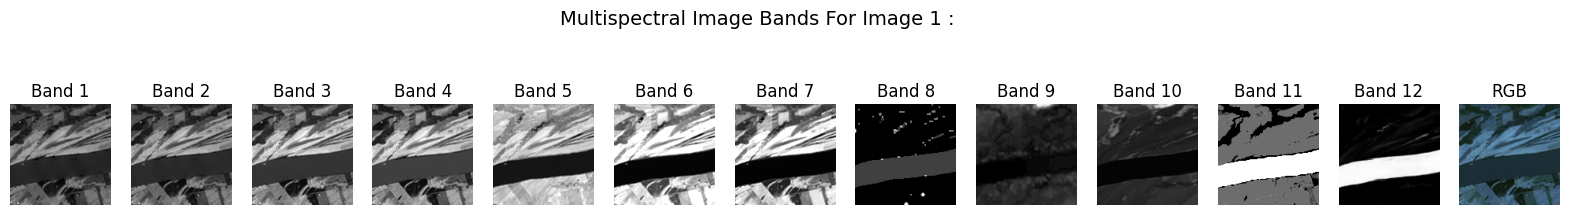

In [12]:
visualize_bands(images[5], title="Multispectral Image Bands For Image 1 : ")

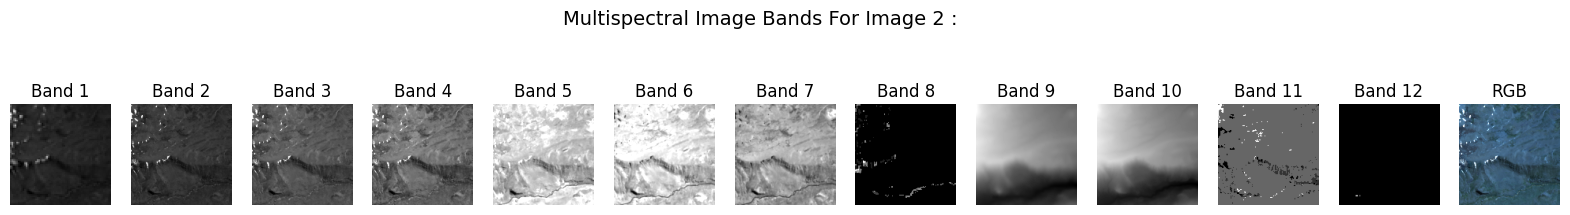

In [13]:
visualize_bands(images[10], title="Multispectral Image Bands For Image 2 :")

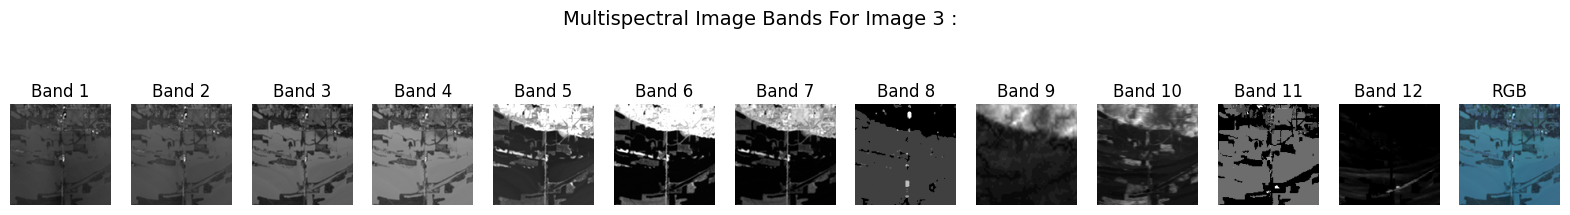

In [14]:
visualize_bands(images[15], title="Multispectral Image Bands For Image 3 :")

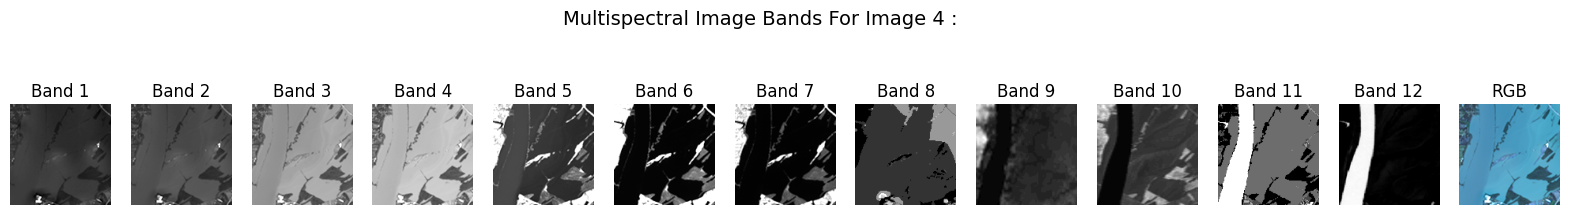

In [15]:
visualize_bands(images[20], title="Multispectral Image Bands For Image 4 :")

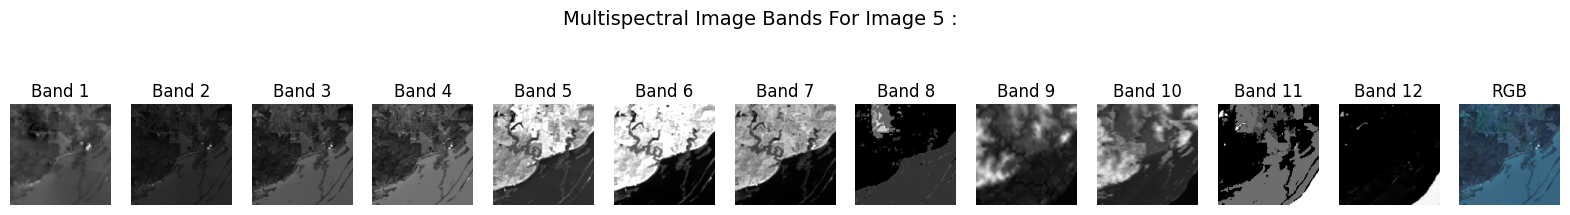

In [16]:
visualize_bands(images[25], title="Multispectral Image Bands For Image 5 :")

# **Splitting The Dataset :**

In [17]:
train_size = int(0.8 * len(images))  # 80% training, 20% validation
X_train, X_val = images[:train_size], images[train_size:]
y_train, y_val = masks[:train_size], masks[train_size:]

# **Fine Tuning The Pretrained UNet Model Architecture , Compiling And Training :**

In [41]:
def pretrained_unet(input_shape=(128, 128, 12)):
    inputs = layers.Input(input_shape)

    # Convert 12 channels to 3 (Ensure compatibility with EfficientNetB0)
    x = layers.Conv2D(3, (1, 1), activation='relu', padding='same')(inputs)

    # EfficientNetV2B0 as Encoder
    backbone = EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
    backbone.trainable = True 

    encoder_output = backbone(x, training=False)  

    # Decoder (Upsample back to 128x128)
    u1 = layers.UpSampling2D((2, 2))(encoder_output)
    c1 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.00101))(u1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Dropout(0.3)(c1)  

    u2 = layers.UpSampling2D((2, 2))(c1)
    c2 = layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.0001))(u2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Dropout(0.3)(c2)

    u3 = layers.UpSampling2D((2, 2))(c2)
    c3 = layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001))(u3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Dropout(0.3)(c3)

    u4 = layers.UpSampling2D((2, 2))(c3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001))(u4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Dropout(0.25)(c4)  # Slightly higher dropout at deeper layers

    u5 = layers.UpSampling2D((2, 2))(c4)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001))(u5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Dropout(0.2)(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c5)  # Final output: (128, 128, 1)

    model = Model(inputs, outputs)
    return model

# Initialize Model
PretrainedUNet = pretrained_unet(input_shape=(128, 128, 12))

# PretrainedUNet with Adam optimizer and learning rate decay
PretrainedUNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping
callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
]

# Post Processing: Convert Probability to Binary Mask
def post_process_mask(mask, threshold=0.5):
    return (mask > threshold).astype(np.uint8)

# Train the model
history = PretrainedUNet.fit(
    np.array(contrast_images[:train_size]), np.array(masks[:train_size]),
    validation_data=(np.array(contrast_images[train_size:]), np.array(masks[train_size:])),
    epochs=300,
    batch_size=32,
    callbacks=callbacks
)

print("Model training complete! ✅")

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 123s 7s/step - accuracy: 0.5288 - loss: 2.9204 - val_accuracy: 0.2426 - val_loss: 13.9997
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.8023 - loss: 2.5138 - val_accuracy: 0.2365 - val_loss: 14.0240
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.8517 - loss: 2.2550 - val_accuracy: 0.5976 - val_loss: 6.1231
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.8637 - loss: 1.8971 - val_accuracy: 0.7635 - val_loss: 4.3255
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.8784 - loss: 1.6045 - val_accuracy: 0.5326 - val_loss: 5.8097
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.8869 - loss: 1.3431 - val_accuracy: 0.3458 - val_loss: 9.7361
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.8964 - loss: 1.1317 - val_accuracy: 0.7720 - val_loss: 1.9640
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.8846 - loss: 0.9755 - val_accuracy: 0.7674 - 

# **Evaluating The Model Performance :**

## Confusion Matrix With Heatmap :

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

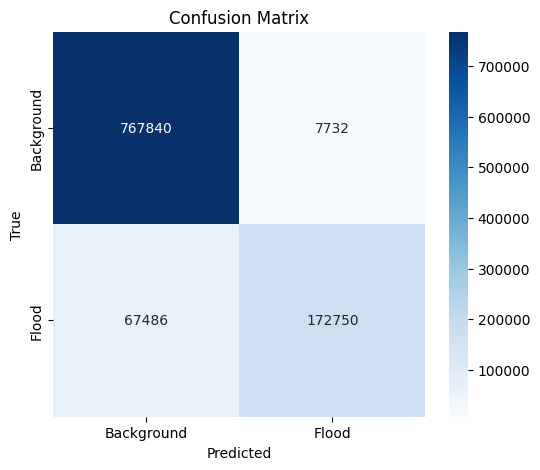

In [75]:
# Compute y_pred efficiently (one image at a time, no big array storage)
y_pred = np.concatenate([
    post_process_mask(PretrainedUNet.predict(np.expand_dims(img, axis=0))[0, :, :, 0]).flatten()
    for img in contrast_images[train_size:]
])

# Ensure y_val is a NumPy array
y_val = np.array(y_val)

# Compute confusion matrix
cm = confusion_matrix(y_val.flatten(), y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Flood'], yticklabels=['Background', 'Flood'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## IoU Matrix, Precision, Recall And F1-Score : 

In [72]:
water_iou = jaccard_score(y_val.flatten(), y_pred, pos_label=1)
water_precision = precision_score(y_val.flatten(), y_pred, pos_label=1)
water_recall = recall_score(y_val.flatten(), y_pred, pos_label=1)
water_f1 = f1_score(y_val.flatten(), y_pred, pos_label=1)

print(f"IoU (Water Class): {water_iou:.4f}")
print(f"Precision (Water Class): {water_precision:.4f}")
print(f"Recall (Water Class): {water_recall:.4f}")
print(f"F1-Score (Water Class): {water_f1:.4f}")


IoU (Water Class): 0.6967
Precision (Water Class): 0.9572
Recall (Water Class): 0.7191
F1-Score (Water Class): 0.8212


## Visualizing The Accuracy And The Loss Of The Model :

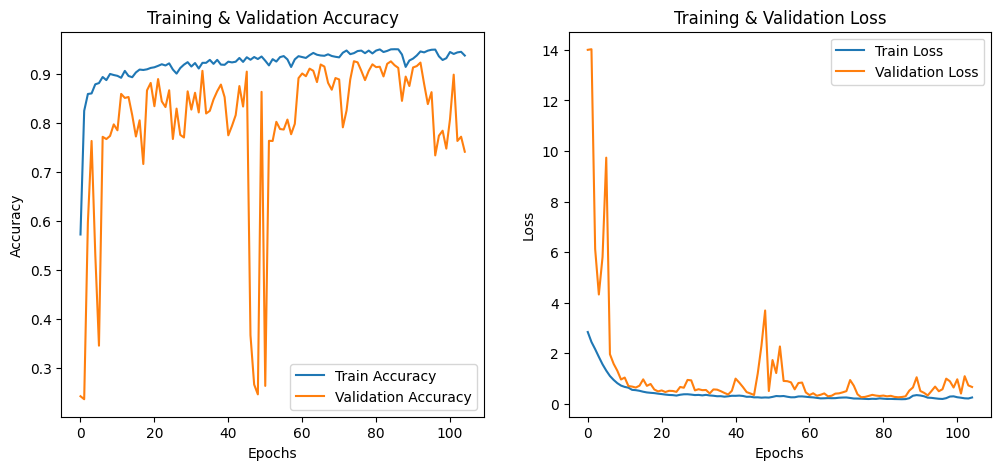

In [73]:
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# **Make Some Predictions :**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


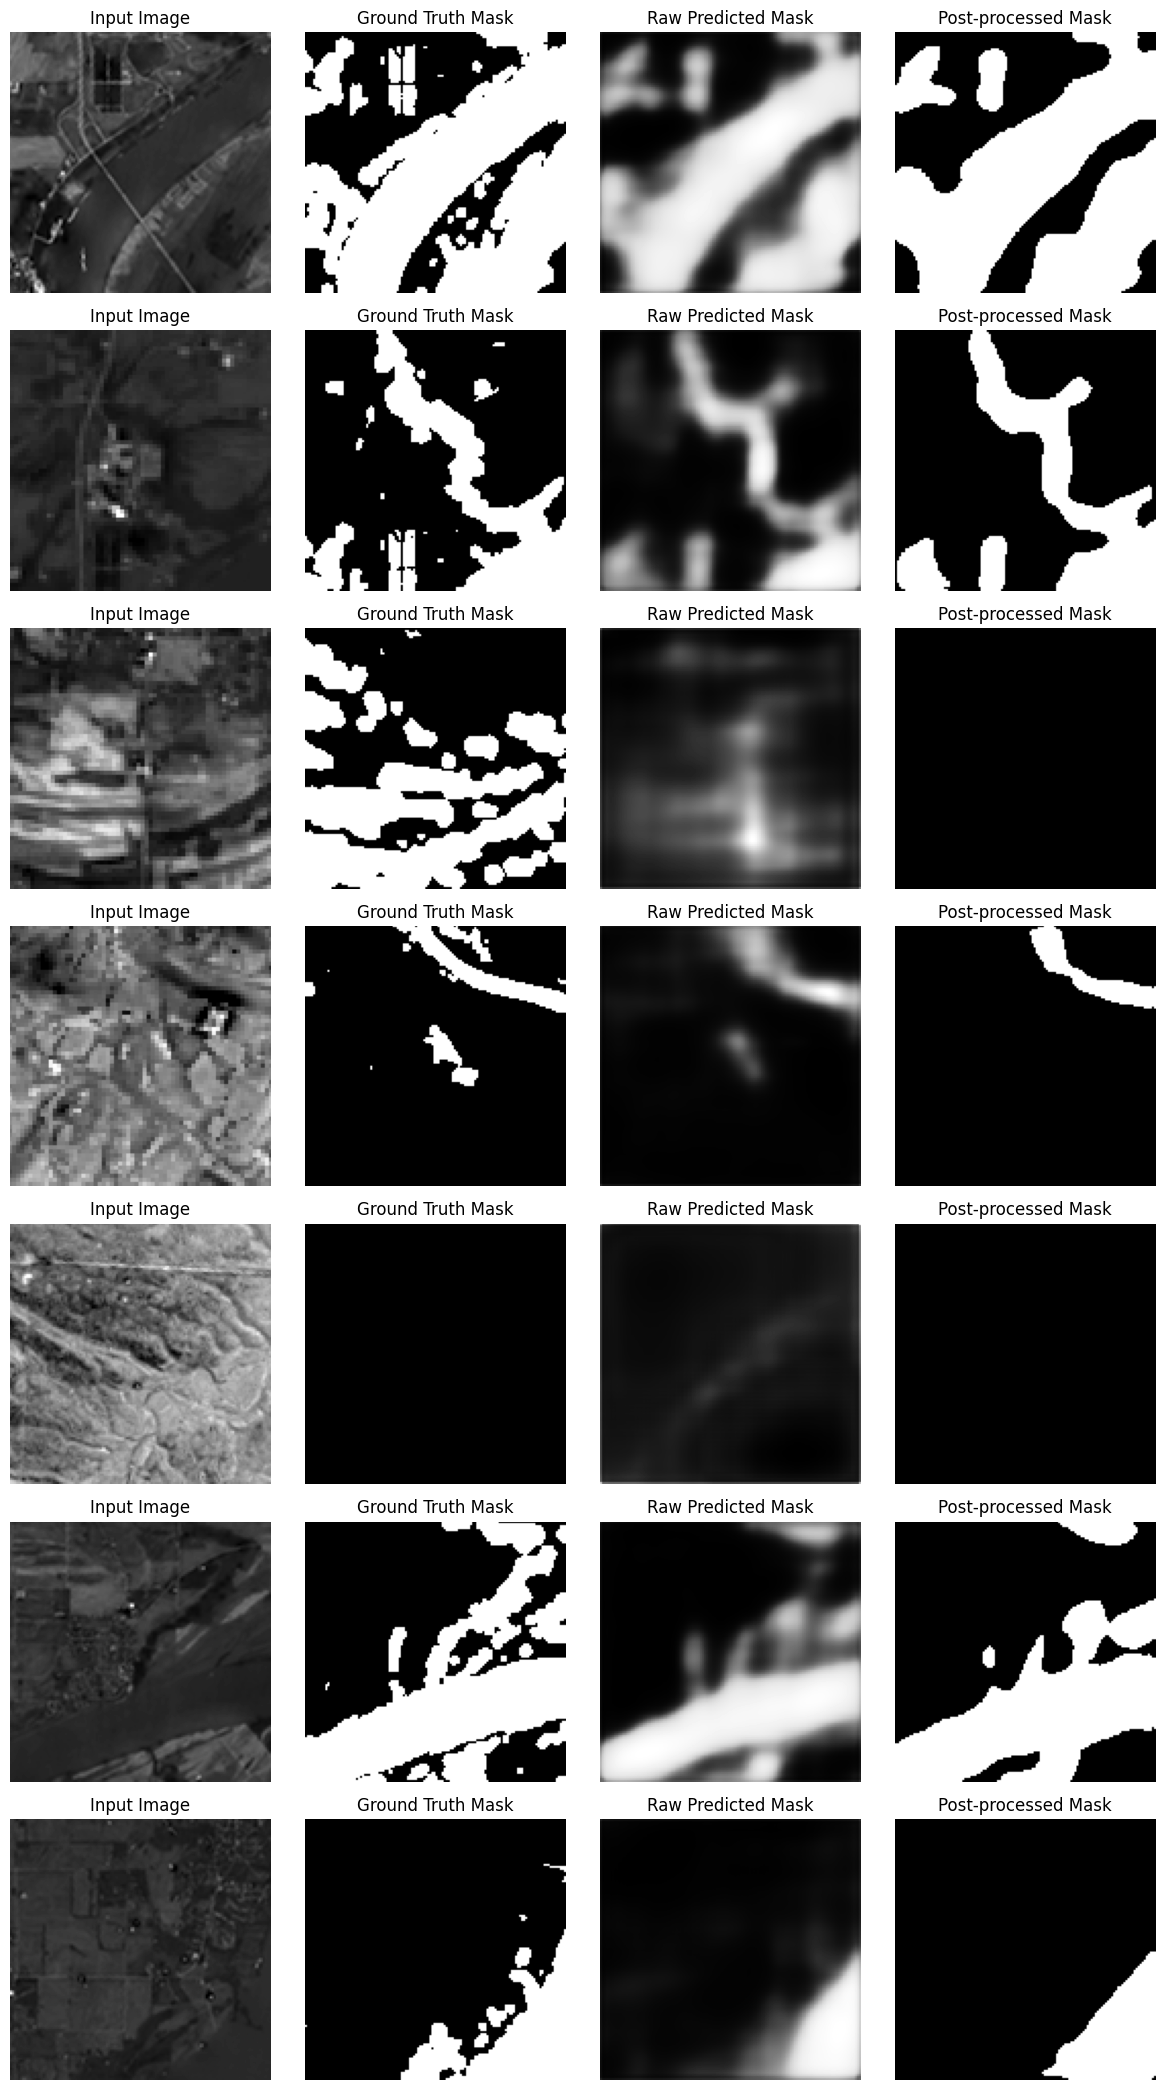

In [61]:
# Post Processing: Convert Probability to Binary Mask
def post_process_mask(mask, threshold=0.3655):
    return (mask > threshold).astype(np.uint8)

# Select random test images
num_samples = 7
indices = random.sample(range(len(contrast_images[train_size:])), num_samples)

fig, axes = plt.subplots(num_samples, 4, figsize=(12, num_samples * 3))

for i, idx in enumerate(indices):
    input_image = contrast_images[train_size + idx]
    ground_truth = masks[train_size + idx]
    
    # Predict mask
    predicted_mask = PretrainedUNet.predict(np.expand_dims(input_image, axis=0))[0, :, :, 0]

    # Apply post-processing
    binary_mask = post_process_mask(predicted_mask)

    # Plot input image
    axes[i, 0].imshow(input_image[:, :, 0], cmap='gray')
    axes[i, 0].set_title("Input Image")
    axes[i, 0].axis("off")

    # Plot ground truth mask
    axes[i, 1].imshow(ground_truth, cmap='gray')
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    # Plot raw predicted mask
    axes[i, 2].imshow(predicted_mask, cmap='gray')  
    axes[i, 2].set_title("Raw Predicted Mask")
    axes[i, 2].axis("off")

    # Plot predicted mask (Post-processed)
    axes[i, 3].imshow(binary_mask, cmap='gray')
    axes[i, 3].set_title("Post-processed Mask")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()


# **Saving The Final Version Of The U-Net Model :**

In [45]:
PretrainedUNet.save("EfficientNetV2B0 Pretrained Model - Object Detection.h5")